# OGGM flowlines: where are they?

In this notebook we show how to access the OGGM flowlines location before, during, and after a run.

Some of the code shown here will make it to the OGGM codebase [eventually](https://github.com/OGGM/oggm/issues/1111).

In [1]:
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import flowline
import salem
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
cfg.initialize(logging_level='WARNING')

2021-02-01 19:37:51: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-01 19:37:51: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-02-01 19:37:51: oggm.cfg: Multiprocessing: using all available processors (N=8)


## Get ready

In [3]:
# Where to store the data 
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-flowlines', reset=True)
# Which glaciers?
rgi_ids = ['RGI60-11.00897']
# We start from prepro level 3 with all data ready
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3, prepro_border=40)
gdir = gdirs[0]
gdir

2021-02-01 19:38:07: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2021-02-01 19:38:07: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


<oggm.GlacierDirectory>
  RGI id: RGI60-11.00897
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Name: Hintereisferner
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 8.036 km2
  Lon, Lat: (10.7584, 46.8003)
  Grid (nx, ny): (199, 154)
  Grid (dx, dy): (50.0, -50.0)

## Where is the terminus?

There are several way to get the terminus, depending on what you want. They are also not necessarily exact same:

### Terminus as the lowest point on the glacier

In [4]:
# Get the topo data and the glacier mask
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    topo = ds.topo
    # Glacier outline raster
    mask = ds.glacier_ext

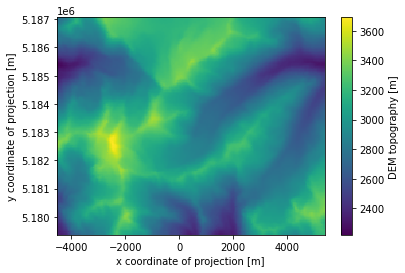

In [5]:
topo.plot();

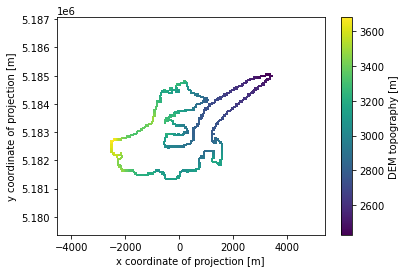

In [6]:
topo_ext = topo.where(mask==1)
topo_ext.plot();

In [7]:
# Get the terminus
terminus = topo_ext.where(topo_ext==topo_ext.min(), drop=True)
# Project its coordinates from the local UTM to WGS-84
t_lon, t_lat = salem.transform_proj(gdir.grid.proj, 'EPSG:4326', terminus.x[0], terminus.y[0])
print(t_lon, t_lat)

10.802746863388563 46.818900914354266


### Terminus as the lowest point on the main centerline

In [8]:
# Get the centerlines
cls = gdir.read_pickle('centerlines')
# Get the coord of the last point of the main centerline
cl = cls[-1]
i, j = cl.line.coords[-1]
# These coords are in glacier grid coordinates. Let's convert them to lon, lat:
t_lon, t_lat = gdir.grid.ij_to_crs(i, j, crs='EPSG:4326')
t_lon, t_lat

(10.802746863955196, 46.818901155282155)

### Terminus as the lowest point on the main flowline 

"centerline" in the OGGM jargon is not the same as "flowline". Flowlines have a fixed dx and their terminus in not necessarily exact on the glacier outline. Code-wise it's very similar though:

In [9]:
# Get the flowlines
cls = gdir.read_pickle('inversion_flowlines')
# Get the coord of the last point of the main centerline
cl = cls[-1]
i, j = cl.line.coords[-1]
# These coords are in glacier grid coordinates. Let's convert them to lon, lat:
t_lon, t_lat = gdir.grid.ij_to_crs(i, j, crs='EPSG:4326')
t_lon, t_lat

(10.802746777546085, 46.818796056851475)

### Bonus: convert the centerlines to a shapefile 

In [10]:
utils.write_centerlines_to_shape(gdirs, path='out.shp')

/home/mowglie/.pyenv/versions/3.8.5/envs/py3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


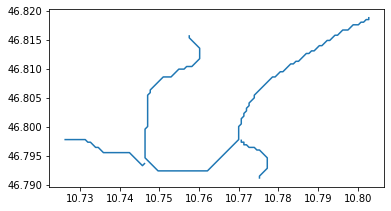

In [11]:
sh = gpd.read_file('out.shp')
sh.plot();

## Flowline geometry after a run with `FileModel`

Let's do a run first:

In [12]:
tasks.init_present_time_glacier(gdir)
tasks.run_constant_climate(gdir, nyears=100, y0=2000);

We use a `FileModel` to read the model output:

In [13]:
fmod = flowline.FileModel(gdir.get_filepath('model_run'))

A FileModel behaves like a OGGM's `FlowlineModel`:

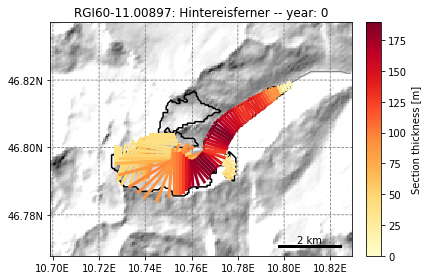

In [14]:
fmod.run_until(0)  # Point the file model to year 0 in the output
graphics.plot_modeloutput_map(gdir, model=fmod)  # plot it

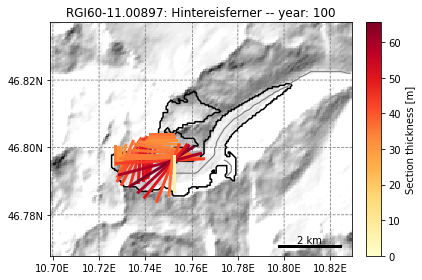

In [15]:
fmod.run_until(100)  # Point the file model to year 100 in the output
graphics.plot_modeloutput_map(gdir, model=fmod)  # plot it

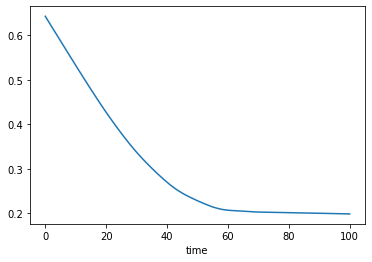

In [16]:
# Bonus - get back to e.g. the volume timeseries
fmod.volume_km3_ts().plot();

OK, now create a table of the main flowline's grid points location and bed altitude (this does not change with time): 

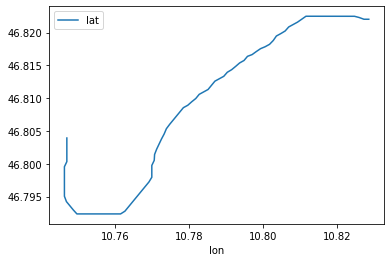

In [18]:
fl = fmod.fls[-1]  # Main flowline
i, j = fl.line.xy  # xy flowline on grid
lons, lats = gdir.grid.ij_to_crs(i, j, crs='EPSG:4326')  # to WGS84

df_coords = pd.DataFrame(index=fl.dis_on_line*gdir.grid.dx)
df_coords.index.name = 'Distance along flowline'
df_coords['lon'] = lons
df_coords['lat'] = lats
df_coords['bed_elevation'] = fl.bed_h
df_coords.plot(x='lon', y='lat');

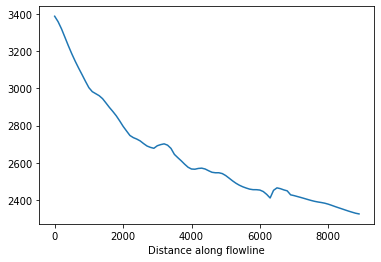

In [19]:
df_coords['bed_elevation'].plot();

Now store a time varying array of ice thickness, surface elevation along this line:

In [20]:
df_thick = pd.DataFrame(index=df_coords.index)
df_surf_h = pd.DataFrame(index=df_coords.index)
df_bed_h = pd.DataFrame()
for year in range(0, 101):
    fmod.run_until(year)
    fl = fmod.fls[-1]
    df_thick[year] = fl.thick
    df_surf_h[year] = fl.surface_h

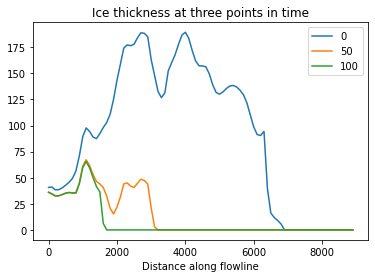

In [21]:
df_thick[[0, 50, 100]].plot();
plt.title('Ice thickness at three points in time');

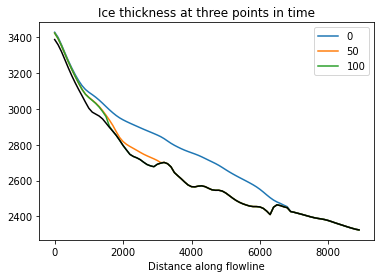

In [22]:
f, ax = plt.subplots()
df_surf_h[[0, 50, 100]].plot(ax=ax);
df_coords['bed_elevation'].plot(ax=ax, color='k');
plt.title('Ice thickness at three points in time');

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)